# Generative adversarial networks (GAN)

In [1]:
import os
from torch.utils.data import DataLoader, dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Подготовка данных

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть.

In [2]:
!sudo apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [3]:
def get_dataloader(image_size=512, batch_size=128):
    if not os.path.exists("dataset"):
        if not os.path.exists("dataset_raw"):
            if not os.path.exists("faces_dataset_small.zip"):
                print("Images not found, downloading...")
                os.system("gdown --id 1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9")
            print("Extracting...")
            os.system("7z x faces_dataset_small.zip -o./dataset_raw")
            os.system("rm -rf ./dataset_raw/__MACOSX")
        print("Processing files...")
        png_path = []
        for dirpath, dirnames, filenames in os.walk("dataset_raw"):
            for fname in filenames:
                if fname.endswith(".png"):
                    png_path += [os.path.join(dirpath, fname)]

        os.makedirs("dataset/1")
        for ind, img in enumerate(png_path):
            resize_arg = str(image_size) + "x" + str(image_size)
            arg = (
                'convert "'
                + img
                + '" -resize '
                + resize_arg
                + " -gravity center -extent "
                + resize_arg
                + " -quality 100% -strip "
                + '"dataset/1/'
                + str(ind)
                + '.jpg"'
            )
            os.system(arg)
        os.system("rm -rf dataset_raw")
        print("Done")

    transform = tt.Compose(
            [
                tt.ToTensor(),
                tt.Normalize(
                    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                ),
            ]
        )
    dataset = ImageFolder("dataset", transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [4]:
image_size = 128
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imageloader = get_dataloader(image_size, batch_size)

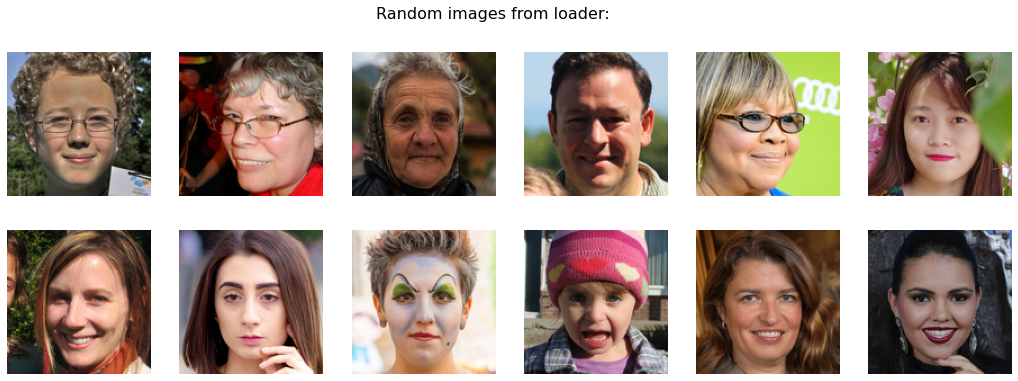

In [5]:
output_to_img = tt.Compose(
    [
        tt.Normalize(
            mean=[-1, -1, -1],
            std=[2, 2, 2],
        ),
        tt.ToPILImage(),
    ]
)

batch = next(iter(imageloader))
fig = plt.figure(figsize=(18, 6))
fig.suptitle("Random images from loader:", fontsize=16)
for indx in range(6):
    plt.subplot(2, 6, indx + 1)
    plt.axis("off")
    plt.imshow(output_to_img(batch[0][indx]))

    plt.subplot(2, 6, indx + 7)
    plt.axis("off")
    plt.imshow(output_to_img(batch[0][indx + 6]))

## Построение и обучение модели

Сконструируем генератор и дискриминатор:

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, latent_size, f_maps_size_gen):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, f_maps_size_gen * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(f_maps_size_gen * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                f_maps_size_gen * 16, f_maps_size_gen * 8, 4, 2, 1, bias=False
            ),
            nn.BatchNorm2d(f_maps_size_gen * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                f_maps_size_gen * 8, f_maps_size_gen * 4, 4, 2, 1, bias=False
            ),
            nn.BatchNorm2d(f_maps_size_gen * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                f_maps_size_gen * 4, f_maps_size_gen * 2, 4, 2, 1, bias=False
            ),
            nn.BatchNorm2d(f_maps_size_gen * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                f_maps_size_gen * 2, f_maps_size_gen, 4, 2, 1, bias=False
            ),
            nn.BatchNorm2d(f_maps_size_gen),
            nn.ReLU(True),
            nn.ConvTranspose2d(f_maps_size_gen, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, f_maps_size_discr):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, f_maps_size_discr, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                f_maps_size_discr,
                f_maps_size_discr * 2,
                4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(f_maps_size_discr * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                f_maps_size_discr * 2,
                f_maps_size_discr * 4,
                4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(f_maps_size_discr * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                f_maps_size_discr * 4,
                f_maps_size_discr * 8,
                4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(f_maps_size_discr * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                f_maps_size_discr * 8,
                f_maps_size_discr * 16,
                4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(f_maps_size_discr * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(f_maps_size_discr * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


Перейдем к обучению GANа.
В качестве функции потерь возьмем бинарную кросс-энтропию.

In [7]:
lr = 0.0016
latent_size = 1024
real_label = 1.0
fake_label = 0.0
num_epochs = 300
img_list = []
G_losses = []
D_losses = []
iters = 0
f_maps_size_discr = 32
f_maps_size_gen = 128
level_of_noise = 0.1

discriminator = Discriminator(f_maps_size_discr).to(device)
discriminator.apply(weights_init)
generator = Generator(latent_size, f_maps_size_gen).to(device)
generator.apply(weights_init)

criterion = nn.BCELoss()
fixed_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=60, gamma=0.5)
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=60, gamma=0.5)

[  0/300][  0/ 24]   Loss_D: 1.7284   Loss_G: 32.9271   D(x): 0.5938   D(G(z)): 0.6199 / 0.0000   lr: 0.0016 / 0.0016  


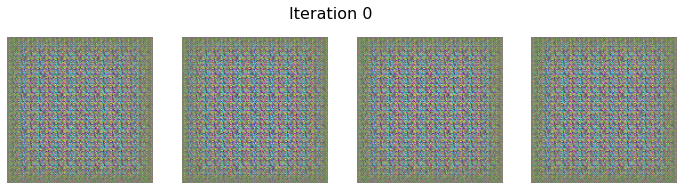

[  1/300][  0/ 24]   Loss_D: 86.4235   Loss_G: 10.2487   D(x): 0.8819   D(G(z)): 1.0000 / 1.0000   lr: 0.0016 / 0.0016  
[  2/300][  0/ 24]   Loss_D: 87.6224   Loss_G: 8.7220   D(x): 0.9883   D(G(z)): 1.0000 / 1.0000   lr: 0.0016 / 0.0016  
[  3/300][  0/ 24]   Loss_D: 0.9602   Loss_G: 1.7987   D(x): 0.8573   D(G(z)): 0.1928 / 0.1991   lr: 0.0016 / 0.0016  
[  4/300][  0/ 24]   Loss_D: 0.8080   Loss_G: 1.9086   D(x): 0.9107   D(G(z)): 0.1697 / 0.1424   lr: 0.0016 / 0.0016  
[  5/300][  0/ 24]   Loss_D: 0.8780   Loss_G: 2.9353   D(x): 0.9291   D(G(z)): 0.1251 / 0.0594   lr: 0.0016 / 0.0016  
[  6/300][  0/ 24]   Loss_D: 1.0052   Loss_G: 2.6713   D(x): 0.9260   D(G(z)): 0.3839 / 0.0662   lr: 0.0016 / 0.0016  
[  7/300][  0/ 24]   Loss_D: 1.2226   Loss_G: 2.0411   D(x): 0.7843   D(G(z)): 0.4799 / 0.1411   lr: 0.0016 / 0.0016  
[  8/300][  0/ 24]   Loss_D: 1.3956   Loss_G: 1.3928   D(x): 0.6055   D(G(z)): 0.3566 / 0.2758   lr: 0.0016 / 0.0016  
[  9/300][  0/ 24]   Loss_D: 1.6670   Loss_G:

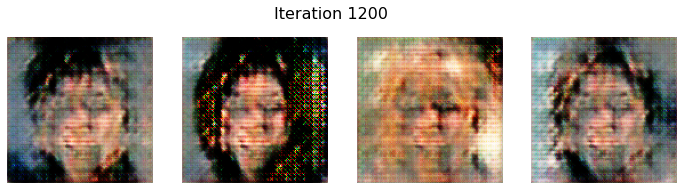

[ 51/300][  0/ 24]   Loss_D: 1.2376   Loss_G: 1.2200   D(x): 0.5482   D(G(z)): 0.3803 / 0.2841   lr: 0.0016 / 0.0016  
[ 52/300][  0/ 24]   Loss_D: 1.2249   Loss_G: 1.2249   D(x): 0.6169   D(G(z)): 0.4455 / 0.2808   lr: 0.0016 / 0.0016  
[ 53/300][  0/ 24]   Loss_D: 1.4299   Loss_G: 1.4222   D(x): 0.5792   D(G(z)): 0.5350 / 0.2346   lr: 0.0016 / 0.0016  
[ 54/300][  0/ 24]   Loss_D: 1.3306   Loss_G: 0.9581   D(x): 0.4610   D(G(z)): 0.3566 / 0.3785   lr: 0.0016 / 0.0016  
[ 55/300][  0/ 24]   Loss_D: 1.2445   Loss_G: 1.0683   D(x): 0.7366   D(G(z)): 0.5330 / 0.3437   lr: 0.0016 / 0.0016  
[ 56/300][  0/ 24]   Loss_D: 1.5839   Loss_G: 3.0291   D(x): 0.7044   D(G(z)): 0.6486 / 0.0599   lr: 0.0016 / 0.0016  
[ 57/300][  0/ 24]   Loss_D: 1.3216   Loss_G: 1.3093   D(x): 0.5441   D(G(z)): 0.4168 / 0.2625   lr: 0.0016 / 0.0016  
[ 58/300][  0/ 24]   Loss_D: 1.2846   Loss_G: 1.2857   D(x): 0.5283   D(G(z)): 0.3816 / 0.2830   lr: 0.0016 / 0.0016  
[ 59/300][  0/ 24]   Loss_D: 1.4473   Loss_G: 0.

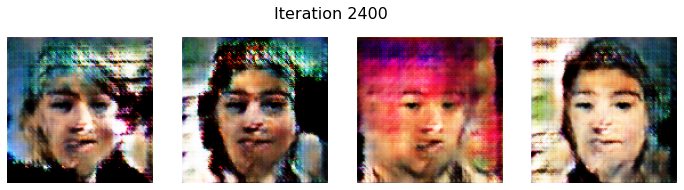

[101/300][  0/ 24]   Loss_D: 1.2354   Loss_G: 2.0168   D(x): 0.7978   D(G(z)): 0.5513 / 0.1312   lr: 0.0008 / 0.0008  
[102/300][  0/ 24]   Loss_D: 1.4986   Loss_G: 3.1775   D(x): 0.8313   D(G(z)): 0.6860 / 0.0367   lr: 0.0008 / 0.0008  
[103/300][  0/ 24]   Loss_D: 0.9415   Loss_G: 1.4937   D(x): 0.7421   D(G(z)): 0.3167 / 0.2078   lr: 0.0008 / 0.0008  
[104/300][  0/ 24]   Loss_D: 1.0158   Loss_G: 1.5515   D(x): 0.6911   D(G(z)): 0.2878 / 0.2067   lr: 0.0008 / 0.0008  
[105/300][  0/ 24]   Loss_D: 1.1476   Loss_G: 2.0471   D(x): 0.7656   D(G(z)): 0.4520 / 0.1185   lr: 0.0008 / 0.0008  
[106/300][  0/ 24]   Loss_D: 1.2808   Loss_G: 2.6604   D(x): 0.8353   D(G(z)): 0.5837 / 0.0786   lr: 0.0008 / 0.0008  
[107/300][  0/ 24]   Loss_D: 1.0983   Loss_G: 1.3381   D(x): 0.5791   D(G(z)): 0.2325 / 0.2611   lr: 0.0008 / 0.0008  
[108/300][  0/ 24]   Loss_D: 1.0340   Loss_G: 2.0350   D(x): 0.7193   D(G(z)): 0.3602 / 0.1218   lr: 0.0008 / 0.0008  
[109/300][  0/ 24]   Loss_D: 1.1953   Loss_G: 1.

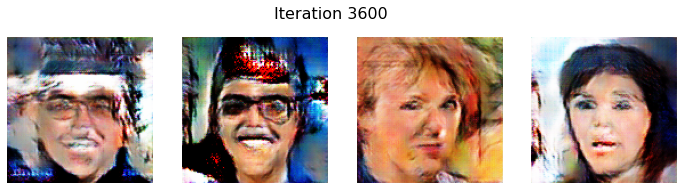

[151/300][  0/ 24]   Loss_D: 1.0812   Loss_G: 3.3122   D(x): 0.8572   D(G(z)): 0.4630 / 0.0350   lr: 0.0004 / 0.0004  
[152/300][  0/ 24]   Loss_D: 0.8845   Loss_G: 1.5582   D(x): 0.7352   D(G(z)): 0.2631 / 0.2093   lr: 0.0004 / 0.0004  
[153/300][  0/ 24]   Loss_D: 1.0791   Loss_G: 1.1668   D(x): 0.5903   D(G(z)): 0.2270 / 0.3299   lr: 0.0004 / 0.0004  
[154/300][  0/ 24]   Loss_D: 1.0122   Loss_G: 1.7428   D(x): 0.7436   D(G(z)): 0.3189 / 0.1771   lr: 0.0004 / 0.0004  
[155/300][  0/ 24]   Loss_D: 0.8952   Loss_G: 1.9817   D(x): 0.7835   D(G(z)): 0.2467 / 0.1381   lr: 0.0004 / 0.0004  
[156/300][  0/ 24]   Loss_D: 0.9026   Loss_G: 1.5133   D(x): 0.7441   D(G(z)): 0.2191 / 0.2191   lr: 0.0004 / 0.0004  
[157/300][  0/ 24]   Loss_D: 1.0364   Loss_G: 2.5384   D(x): 0.8280   D(G(z)): 0.4336 / 0.0753   lr: 0.0004 / 0.0004  
[158/300][  0/ 24]   Loss_D: 0.9007   Loss_G: 1.9469   D(x): 0.7357   D(G(z)): 0.2340 / 0.1461   lr: 0.0004 / 0.0004  
[159/300][  0/ 24]   Loss_D: 0.9103   Loss_G: 1.

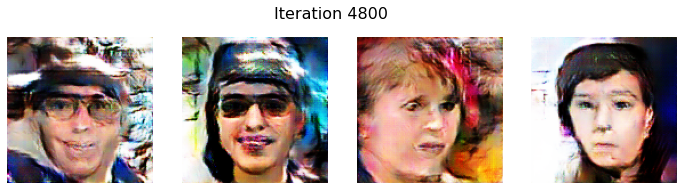

[201/300][  0/ 24]   Loss_D: 0.8717   Loss_G: 1.3845   D(x): 0.7444   D(G(z)): 0.1852 / 0.2543   lr: 0.0002 / 0.0002  
[202/300][  0/ 24]   Loss_D: 0.8022   Loss_G: 1.7338   D(x): 0.8253   D(G(z)): 0.2159 / 0.1763   lr: 0.0002 / 0.0002  
[203/300][  0/ 24]   Loss_D: 0.8447   Loss_G: 1.3592   D(x): 0.7553   D(G(z)): 0.2022 / 0.2671   lr: 0.0002 / 0.0002  
[204/300][  0/ 24]   Loss_D: 0.8475   Loss_G: 1.9234   D(x): 0.8107   D(G(z)): 0.2224 / 0.1500   lr: 0.0002 / 0.0002  
[205/300][  0/ 24]   Loss_D: 0.8459   Loss_G: 1.4313   D(x): 0.7405   D(G(z)): 0.1905 / 0.2436   lr: 0.0002 / 0.0002  
[206/300][  0/ 24]   Loss_D: 0.8487   Loss_G: 1.2815   D(x): 0.7488   D(G(z)): 0.1717 / 0.2846   lr: 0.0002 / 0.0002  
[207/300][  0/ 24]   Loss_D: 0.8123   Loss_G: 2.0174   D(x): 0.8697   D(G(z)): 0.2493 / 0.1293   lr: 0.0002 / 0.0002  
[208/300][  0/ 24]   Loss_D: 0.8576   Loss_G: 1.7462   D(x): 0.7936   D(G(z)): 0.2300 / 0.1804   lr: 0.0002 / 0.0002  
[209/300][  0/ 24]   Loss_D: 0.8349   Loss_G: 1.

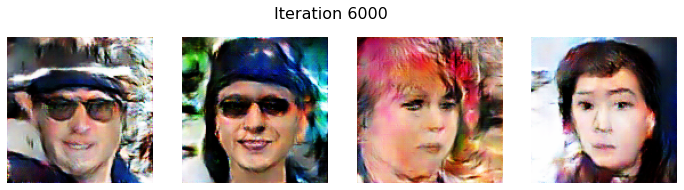

[251/300][  0/ 24]   Loss_D: 0.7843   Loss_G: 1.7507   D(x): 0.8641   D(G(z)): 0.2740 / 0.1776   lr: 0.0001 / 0.0001  
[252/300][  0/ 24]   Loss_D: 0.7780   Loss_G: 1.7354   D(x): 0.8567   D(G(z)): 0.2200 / 0.1782   lr: 0.0001 / 0.0001  
[253/300][  0/ 24]   Loss_D: 0.8214   Loss_G: 1.6499   D(x): 0.8513   D(G(z)): 0.2357 / 0.1938   lr: 0.0001 / 0.0001  
[254/300][  0/ 24]   Loss_D: 0.7626   Loss_G: 1.6693   D(x): 0.8487   D(G(z)): 0.2043 / 0.1854   lr: 0.0001 / 0.0001  
[255/300][  0/ 24]   Loss_D: 0.8105   Loss_G: 1.6916   D(x): 0.8443   D(G(z)): 0.2006 / 0.1873   lr: 0.0001 / 0.0001  
[256/300][  0/ 24]   Loss_D: 0.8178   Loss_G: 1.6111   D(x): 0.8025   D(G(z)): 0.1705 / 0.1993   lr: 0.0001 / 0.0001  
[257/300][  0/ 24]   Loss_D: 0.8452   Loss_G: 1.6676   D(x): 0.8390   D(G(z)): 0.1950 / 0.1795   lr: 0.0001 / 0.0001  
[258/300][  0/ 24]   Loss_D: 0.8221   Loss_G: 1.6647   D(x): 0.8523   D(G(z)): 0.2466 / 0.1806   lr: 0.0001 / 0.0001  
[259/300][  0/ 24]   Loss_D: 0.7795   Loss_G: 1.

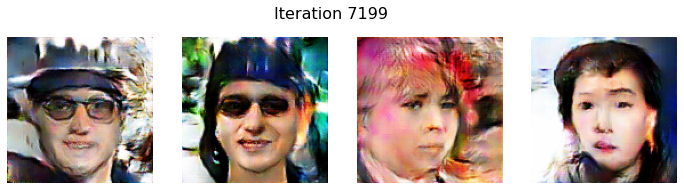

Done


In [8]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        tensor = tensor.to(device)
        return tensor + (torch.randn(tensor.size()) * self.std + self.mean).to(device)


def noisy_labels(y, p_flip=0.05):
    n_select = int(p_flip * y.size(0))
    flip_ix = torch.randperm(y.size(0))[:n_select]
    y[flip_ix] = 1 - y[flip_ix]
    return y


for epoch in range(num_epochs):
    for i, data in enumerate(imageloader, 0):

        std_gaussian = max(
            0, level_of_noise - ((level_of_noise * 2) * (epoch / num_epochs))
        )
        AddGaussianNoiseInst = AddGaussianNoise(
            std=std_gaussian
        )  # the noise decays over time

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        discriminator.zero_grad()
        real_b = data[0].to(device)
        real_b = AddGaussianNoiseInst(real_b)
        output = discriminator(real_b).flatten(1)
        smooth = torch.rand(batch_size, output.size(1)).to(device) * 0.2
        label = (
            torch.full(
                (batch_size, output.size(1)),
                real_label,
                dtype=torch.float,
                device=device,
            )
            - smooth
        )
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake = generator(noise)
        label = noisy_labels(label.fill_(fake_label) + smooth)
        output = discriminator(fake.detach()).flatten(1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label = label.fill_(real_label) - smooth
        output = discriminator(fake).flatten(1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if iters % 24 == 0:
            print(
                "[{:>3d}/{:>3d}][{:>3d}/{:>3d}]   Loss_D: {:>3.4f}   Loss_G: {:>3.4f}   D(x): {:>3.4f}   D(G(z)): {:>3.4f} / {:>3.4f}   lr: {:>3.4f} / {:>3.4f}  ".format(
                    epoch,
                    num_epochs,
                    i,
                    len(imageloader),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                    optimizerD.param_groups[0]["lr"],
                    optimizerG.param_groups[0]["lr"],
                )
            )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % (24 * 50) == 0) or (
            (epoch == num_epochs - 1) and (i == len(imageloader) - 1)
        ):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            fig = plt.figure(figsize=(12, 3))
            fig.suptitle("Iteration " + str(iters), fontsize=16)
            for indx in range(4):
                plt.subplot(1, 4, indx + 1)
                plt.axis("off")
                plt.imshow(output_to_img(fake[indx]))
            plt.show()

        iters += 1
    schedulerD.step()
    schedulerG.step()
print("Done")

Построим графики лосса для генератора и дискриминатора:


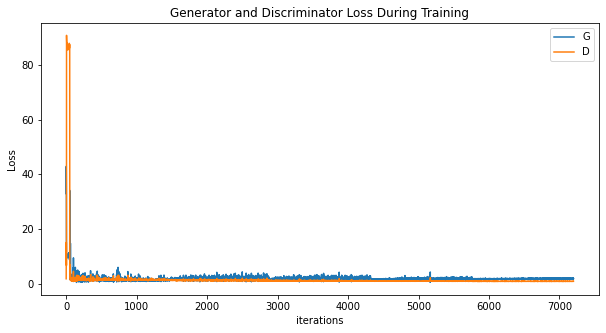

In [9]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Графики хорошие, обучение выглядит стабильным. Без использования некоторых трюков (вроде шума на изображениях, мягких меток и т.п.) на графиках чаще появлялись резкие пики, да и модель легче попадала в необучаемое состояние.
В данном случае такого не наблюдается.

## Генерация изображений

Теперь оценим качество получившихся изображений:

In [10]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = generator(fixed_latent)

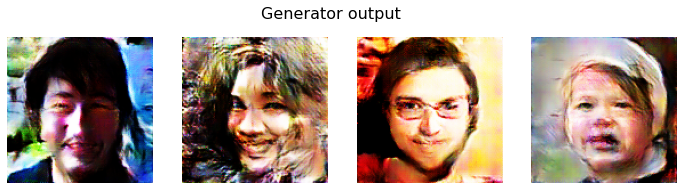

In [11]:
def show_images(generated):
    imgs_amount = generated.size(0)
    rows = imgs_amount // 5 + 1
    cols = imgs_amount if imgs_amount < 5 else 5
    fig = plt.figure(figsize=(3 * cols, 3 * rows))
    fig.suptitle("Generator output", fontsize=16)
    for indx in range(imgs_amount):
        plt.subplot(rows, cols, indx + 1)
        plt.axis("off")
        plt.imshow(output_to_img(generated[indx]))
    plt.show()


show_images(fake_images)

Выглядит средне, лица несколько размыты.

## Leave-one-out-1-NN classifier accuracy

### Подсчет accuracy

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы предлагается следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте.

In [12]:
# Сделаем аналог leave-one-out, который работает с pytorch dataloader

neigh = KNeighborsClassifier(n_neighbors=1)
k_fold = 3

accuracy_r = []
accuracy_f = []

total_size = len(imageloader.dataset)
fraction = 1 / k_fold
seg = int(total_size * fraction)

for i in range(k_fold):
    trll = 0
    trlr = i * seg
    vall = trlr
    valr = i * seg + seg
    trrl = valr
    trrr = total_size

    train_left_indices = list(range(trll, trlr))
    train_right_indices = list(range(trrl, trrr))

    train_indices = train_left_indices + train_right_indices
    val_indices = list(range(vall, valr))

    train_set = torch.utils.data.dataset.Subset(imageloader.dataset, train_indices)
    val_set = torch.utils.data.dataset.Subset(imageloader.dataset, val_indices)

    train_len = len(train_set)
    val_len = len(val_set)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_len)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=val_len)

    tr_real, _ = next(iter(train_loader))
    tr_real = tr_real.cpu()
    with torch.no_grad():
        tr_fake = generator(
            torch.randn(train_len, latent_size, 1, 1, device=device).detach()
        ).cpu()
    tr_imgs = torch.cat((tr_real, tr_fake), 0).flatten(1)
    neigh.fit(tr_imgs, [1] * train_len + [0] * train_len)

    val_real, _ = next(iter(val_loader))
    val_real = val_real.cpu().flatten(1)
    with torch.no_grad():
        val_fake = generator(
            torch.randn(val_len, latent_size, 1, 1, device=device).detach()
        ).cpu().flatten(1)

    y_pred_r = neigh.predict(val_real)
    accuracy_r += [accuracy_score([1] * val_len, y_pred_r)]

    y_pred_f = neigh.predict(val_fake)
    accuracy_f += [accuracy_score([0] * val_len, y_pred_f)]
    print("Accuracy", i + 1, ": real -", accuracy_r[i], "fake -", accuracy_f[i])

print("Average: real -", np.array(accuracy_r).mean(), "fake - ", np.array(accuracy_f).mean())

Accuracy 1 : real - 0.7172874880611271 fake - 0.5530085959885387
Accuracy 2 : real - 0.6389684813753582 fake - 0.670487106017192
Accuracy 3 : real - 0.6303724928366762 fake - 0.6953199617956065
Average: real - 0.6622094874243872 fake -  0.6396052212671124


В идеале хотелось бы получить accuracy 0.5 и там, и там.
Такой результат говорил бы о том, что 1NN не может различать настоящие и фальшивые изображения. Но, к сожалению, генератор не идеален, поэтому алгоритм способен слегка различать картинки.

### Визуализация распределений

Посмотрим насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуемся методом, снижающим размерность (TSNE) и изобразим на графике разным цветом точки, соответствующие реальным и сгенерированным изображениям.

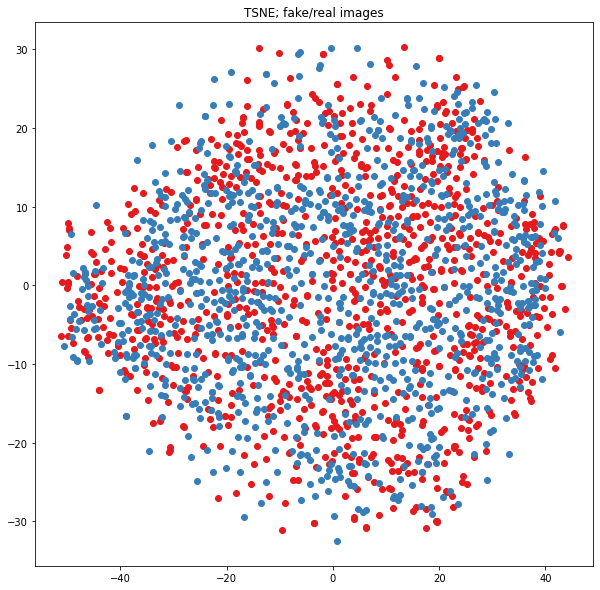

In [13]:
val_imgs = torch.cat((val_real, val_fake), 0)
model_tsne = TSNE(n_components=2, random_state=42)
data = model_tsne.fit_transform(val_imgs)
classes = np.array([1] * val_len + [0] * val_len)
fig = plt.figure(figsize=(10, 10))
for ind in range(len(classes)):
    indxs = np.where(classes == ind)
    color = plt.cm.Set1(ind)
    plt.scatter(data[indxs][:, 0], data[indxs][:, 1], color=color)
plt.title("TSNE; fake/real images")
plt.show()

Результат неплохой, TSNE считает реальные и фальшивые изображения схожими объектами